In [147]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [213]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)  # efficiency
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        # Make it possible that other is a number
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # Avoid overwriting by setting '=' to '+='
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only support int or float power for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    # e.g. 2 * x
    def __rmul__(self, other):
        return self * other

    # Not covered in the video but needed 
    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # Toplogical sort, left to right 
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [214]:
# a = Value(2, label='a')
# b = Value(3, label='b')
# # c = a + b # Same as a.__add__(b)
# # d = c * a * b + c # Same as c.__mul__(a).__mul__(b).__add__(c)
# # d._prev, d._op # Returns 30 and 5, and the operation +
# c = Value(5, label='c')
# e = a * b; e.label='e'
# d = c + e; d.label='d'
# a = Value(2, label='a')
# b = Value(3, label='b')
# a - b # a / b # a ** b # a * b # a + b

In [215]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node
        dot.node(uid, label= "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op: 
            # if this value is a result of some operation, create an op node
            dot.node(name = uid + n._op, label=n._op)
            # connect the op node to the value node
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [216]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.881375, label='b')
# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [217]:
# o.grad = 1.0
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# x1._backward()
# x2._backward()
# w1._backward()
# w2._backward()

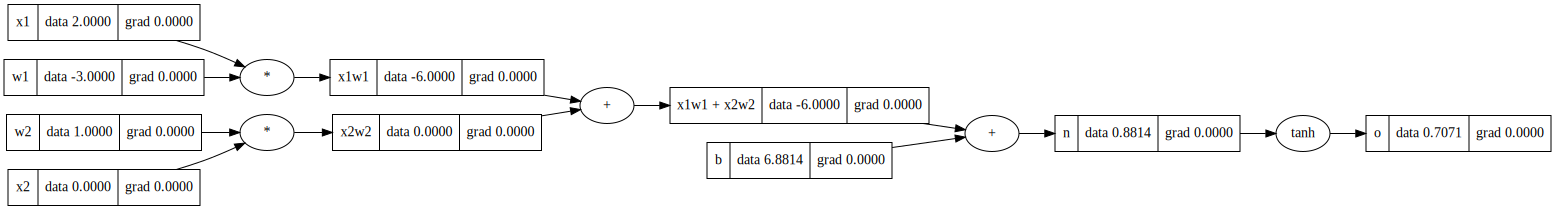

In [218]:
draw_dot(o)

In [219]:
o.backward()

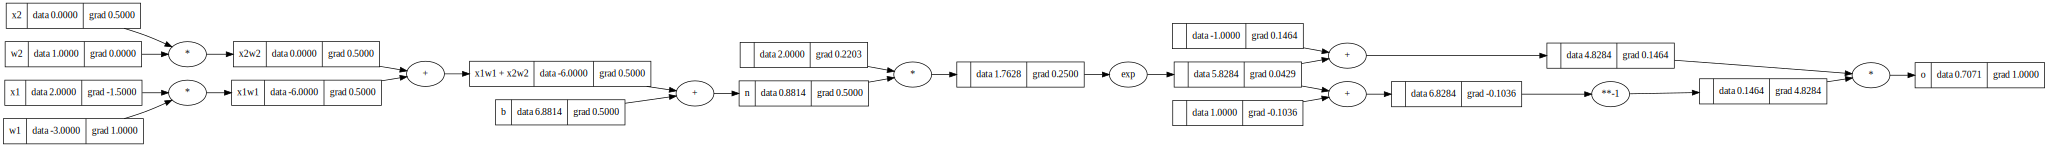

In [220]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.881375, label='b')
# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
#-------------------
e = (2*n).exp()
o = (e - 1)/(e + 1)
#-------------------
o.label='o'
o.backward()
draw_dot(o)

In [221]:
# Now with PyTorch
import torch

x1 = torch.Tensor([2.0]).double()           ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()           ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()          ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()           ; w2.requires_grad = True
b = torch.Tensor([6.8813735870]).double()       ; b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('--------------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
--------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [242]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [257]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
# draw_dot(n(x))

In [258]:
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # Desired outputs
ypred = [n(x) for x in xs]
ypred

[Value(data=0.49591067495697977),
 Value(data=0.15116429747976373),
 Value(data=0.6017394799462592),
 Value(data=0.6455911902758277)]

In [266]:
for k in range(50):
    # Forward pass
    ypred = [n(x) for x in xs]

    # Compute loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Update parameters
    for p in n.parameters():
        p.data += -0.5 * p.grad
        
    print(k, loss.data)


0 0.0012746134889988553
1 0.0012491676388032753
2 0.0012246871753921348
3 0.001201118755535158
4 0.0011784128741529664
5 0.0011565235263087113
6 0.0011354079042271885
7 0.00111502612518479
8 0.001095340986667162
9 0.0010763177456636836
10 0.0010579239193718286
11 0.0010401291049303748
12 0.0010229048160981923
13 0.0010062243350515557
14 0.0009900625776944627
15 0.000974395971068274
16 0.0009592023416130217
17 0.0009444608131779495
18 0.0009301517138043893
19 0.0009162564904145686
20 0.0009027576306361642
21 0.0008896385910769012
22 0.0008768837314375997
23 0.0008644782539176445
24 0.000852408147424061
25 0.0008406601361465227
26 0.000829221632105329
27 0.0008180806913194124
28 0.0008072259732767653
29 0.0007966467034209221
30 0.000786332638395436
31 0.0007762740338128364
32 0.0007664616143371676
33 0.0007568865458888862
34 0.000747540409798754
35 0.000738415178753549
36 0.0007295031943902068
37 0.0007207971464087375
38 0.000712290053084937
39 0.0007039752430751381
40 0.0006958463384140

In [267]:
ypred

[Value(data=0.9880700896497618),
 Value(data=-0.9957050904925466),
 Value(data=-0.9823237608567223),
 Value(data=0.9874737266636758)]